# Food recognition (with VGG-16 base)
input image including some food -> output label (name of food)

Resources:
- comparison of existing image recognition models by size and accuracy
    - https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4
- preprocessing with image augmentation to reduce overfitting + useful visualization of results
    - https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/#ImplementationofaCNNinKeras
- vgg16 with food101
    - https://www.kaggle.com/code/kmader/food-train-vgg16-from-scratch/notebook
    - https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
- building an image data pipeline
    - https://cs230.stanford.edu/blog/datapipeline/#building-an-image-data-pipeline
    - https://www.youtube.com/watch?v=VFEOskzhhbc
- look into transfer learning with vgg-16, to get better results with less data 
    - https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4
    - https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9
- look into allowing multi-class prediction / multiple objects in one image
    - https://pyimagesearch.com/2020/10/12/multi-class-object-detection-and-bounding-box-regression-with-keras-tensorflow-and-deep-learning/

## Data Preparation

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras_preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from glob import glob
import pandas as pd

mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

MessageError: ignored

### Load food dataset:

(Hub) food-recognition-2022: https://www.kaggle.com/code/sainikhileshreddy/how-to-use-the-dataset/notebook
- multiple object classifications, bounding boxes

(Hub) food-101-dataset-train: https://app.activeloop.ai/activeloop/food-101-dataset-train
- single object classifications

food-101 from file structure usage
- http://blog.stratospark.com/deep-learning-applied-food-classification-deep-learning-keras.html
- https://www.kaggle.com/code/themlphdstudent/food-classification-using-inceptionv3/notebook


In [ ]:
#ds_train_original = hub.load('hub://activeloop/food-101-dataset-train')
#ds_train_original, info = tfds.load('food101', split='train', with_info=True)

# Download raw food101 dataset to file structure.
#   I attempted first to use Hub datasets, however after banging my head against
#   a wall finally gave up because they don't appear to be integrated very well
#   with tensorflow. Or at least, I couldn't figure it out, and kept running into
#   more and more problems the deeper I went. 
#   Second I tried to use tfds.load to load food101 straight as a tf Dataset. 
#   But I couldn't figure out how to get the class label names, and in general
#   am confounded with the enigma of the tf Dataset structure when I'm not the
#   one that creates it, so figured by this point I should just download the 
#   raw files because I know how to deal with a file structure, and I know how 
#   to later add more custom data to said file structure. 
#   (ie, making a data folder for bananas, and adding my own data.)
#   So here we are:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar xzvf food-101.tar.gz
clear_output()

class_names & num_classes

In [ ]:
food_101_classes_to_use = ['tacos', 'waffles', 'sushi', 'pizza', 'nachos', 'pancakes', 'hamburger', 'guacamole', 'donuts', 'hot_dog']
custom_classes_to_use = ['banana']
class_names = food_101_classes_to_use + custom_classes_to_use
class_names = sorted(class_names)

num_classes = len(class_names)
print("number of classes: ", num_classes)
print("sorted class_names: ", class_names)

Grab custom class food images from gdrive (not included in food101)

In [ ]:
gdrive_dir = '/content/drive/MyDrive/School/B457 Computer Vision/custom-foods'
custom_images = glob(os.path.join('drive', 'MyDrive', 'School', 'B457 Computer Vision', 'custom-foods', '*', '*'))
print('# custom images:', len(custom_images))
custom_images[1]

Prepare data into a pd dataframe, so that it can easily be prepared later into a tf Dataset

In [ ]:
# grab list of all image filepaths
all_images = glob(os.path.join('food-101', 'images', '*', '*')) + custom_images
# filter to images with the classes we are interested in
all_images = list(filter(lambda x: x.split('/')[-2] in class_names, all_images))
# save the image count for later
image_count = len(all_images)
# create the df with path column
df = pd.DataFrame(dict(path = all_images))
# add class_name column
df['class_name'] = df['path'].map(lambda x: x.split('/')[-2])
# add class column
# (class is the one-hot-encoded version of the class_name, ordered the same as the class_names list)
df['class'] = df['class_name'].map(lambda x: to_categorical(class_names.index(x), num_classes=num_classes).tolist())
# print image count
print(image_count)
# show sample of df
df.sample(3)

Train/test split

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, 
                                   test_size = 0.2, 
                                   random_state = 2022,
                                   stratify = df['class_name'])
print('train', train_df.shape[0], 'test', test_df.shape[0])
train_size = train_df.shape[0]
test_size = test_df.shape[0]

In [ ]:
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

train_generator = ImageDataGenerator(
    brightness_range=[0.1, 0.7], # random brightness range
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15,       # 15% of the data will be used for validation at end of each epoch
    preprocessing_function=preprocess_input # vgg-16 preprocessing
)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

traingen = train_generator.flow_from_dataframe(train_df,
                                               directory='/content/',
                                               x_col='path',
                                               y_col='class_name',
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), # vgg-16 takes images in 224x224
                                               color_mode='rgb', # force any grayscale images to rgb
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_names,
                                               subset='training',
                                               shuffle=True,
                                               seed=2022)

validgen = train_generator.flow_from_dataframe(train_df,
                                               directory='/content/',
                                               x_col='path',
                                               y_col='class_name',
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), # vgg-16 takes images in 224x224
                                               color_mode='rgb', # force any grayscale images to rgb
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_names,
                                               subset='validation',
                                               shuffle=True,
                                               seed=2022)

testgen = test_generator.flow_from_dataframe(test_df,
                                             directory='/content/',
                                             x_col='path',
                                             y_col='class_name',
                                             target_size=(IMG_WIDTH, IMG_HEIGHT), # vgg-16 takes images in 224x224
                                             color_mode='rgb', # force any grayscale images to rgb
                                             batch_size=1,
                                             class_mode='categorical',
                                             classes=class_names,
                                             shuffle=False,
                                             seed=2022)


## Implementing with VGG-16

Load the base pretrained vgg-16 model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# load the VGG-16 model from keras
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)) # include_top=False to remove the classification layers for the original dataset
base_model.trainable = False # Not trainable weights; we don't want to modify the pretrained ImageNet weights

Add the last layers to train for our specific problem

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model, # VGG-16 base model
    layers.Flatten(), # flatten layer
    layers.Dense(4096, activation='relu'), # dense layer 1
    layers.Dense(1072, activation='relu'), # dense layer 2
    layers.Dropout(0.2), # Dropout layer to combat overfitting
    layers.Dense(num_classes, activation='softmax') # prediction layer
])

## Training

In [ ]:
!pip install livelossplot --quiet # install package to show live plot which updates between training epochs

     |████████████████████████████████| 793 kB 5.9 MB/s 
     |████████████████████████████████| 381 kB 42.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.32.0 which is incompatible.


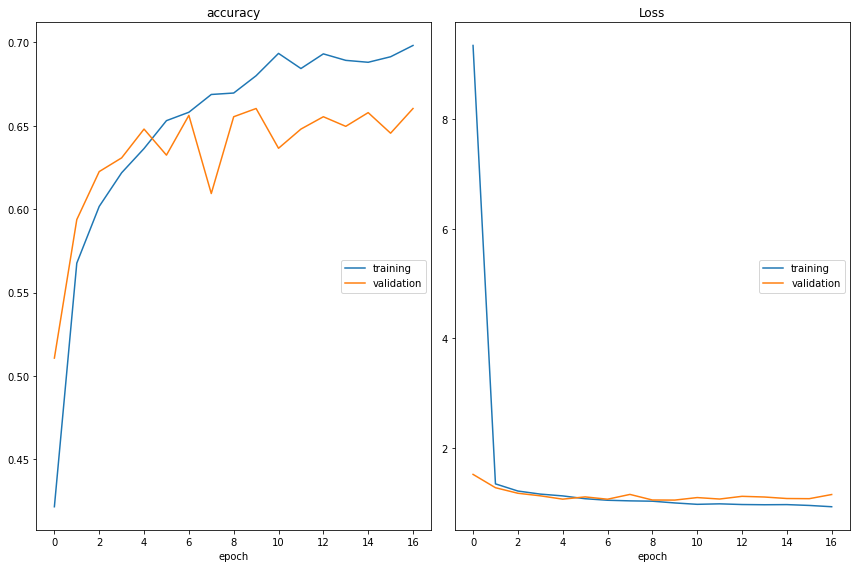

accuracy
	training         	 (min:    0.422, max:    0.698, cur:    0.698)
	validation       	 (min:    0.511, max:    0.660, cur:    0.660)
Loss
	training         	 (min:    0.926, max:    9.346, cur:    0.926)
	validation       	 (min:    1.048, max:    1.517, cur:    1.149)
217/217 [==============================] - 175s 804ms/step - loss: 0.9262 - accuracy: 0.6982 - val_loss: 1.1491 - val_accuracy: 0.6604


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot import PlotLossesKeras


model.compile(
    optimizer='adam', # adam defaults to learning rate=0.001
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# ModelCheckpoint callback - save best weights after each epoch
checkpoint_weights_filepath = 'model_v2.weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_weights_filepath,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  verbose=1)

# Early Stopping callback - stops early if no improvement is noted, restoring best weights
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=7,  restore_best_weights=True)


n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE

history = model.fit(traingen,
                    validation_data=validgen,
                    steps_per_epoch=n_steps,
                    validation_steps=n_val_steps,
                    epochs=25,
                    callbacks=[es, checkpoint, PlotLossesKeras()])

# Testing

In [ ]:
# load best checkpoint version of model
model.load_weights(checkpoint_weights_filepath)

# save the entire model, not just the weights (so we can use it easily in the software later)
model.save('model_v2.best.hdf5')

# run a prediction on the test data
predictions = model.predict(testgen)
predicted_classes = np.argmax(predictions, axis=1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

In [ ]:
# The functions provided in this block of code for results visualization are being used directly from author James McDermott at learndatasci.com
# https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/#ImplementationofaCNNinKeras

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx][0]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Overall Categorical Accuracy: 75.97%


,Precision,Recall,F-Score,Support
banana,0.962963,1.000,0.981132,52.0
pizza,0.939227,0.850,0.892388,200.0
guacamole,0.821256,0.850,0.835381,200.0
donuts,0.835897,0.815,0.825316,200.0
sushi,0.837209,0.720,0.774194,200.0
waffles,0.843373,0.700,0.765027,200.0
hot_dog,0.775956,0.710,0.741514,200.0
hamburger,0.728205,0.710,0.718987,200.0
pancakes,0.594406,0.850,0.699588,200.0
tacos,0.698413,0.660,0.678663,200.0


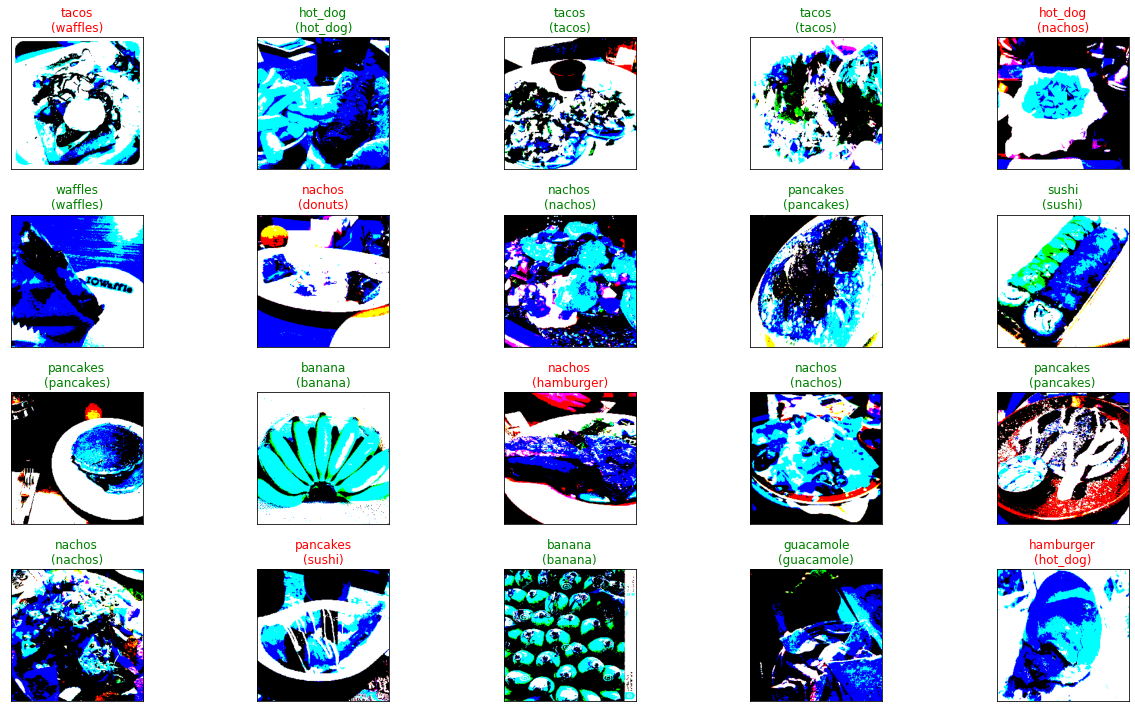

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)
display_results(true_classes, predicted_classes, class_indices.values())